In [2]:
import torch 
import numpy as np 
import VirusDataset 
import ioutils 
import random 
import pandas as pd
import pytorch_lightning as L
import importlib 
importlib.reload(VirusDataset)
strategy = L.strategies.DeepSpeedStrategy()

[2024-07-11 21:16:05,536] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  please install triton==1.0.0 if you want to use sparse attention


## hello

In [2]:
import random
random.seed(1509)
torch.manual_seed(1509)

In [1]:
import torch 
a = torch.tensor((1,23))

In [3]:
import esm 
import VirusDataset  
import importlib 
importlib.reload(VirusDataset)
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = alphabet.get_batch_converter()


In [40]:
X1, y, X2 = VirusDataset.readVirusSequences(trunc=998)
newX1 = [(y, x[1]) for x, y in zip(X1, y)] 
_, _, X1 = batch_converter(X1)
X2_labels, _, X2 = batch_converter(X2)
trainset = VirusDataset.SeqDataset2(X1, y, X2[random.sample(range(X2.shape[0]), X1.shape[0])])
testset = VirusDataset.TestDataset(X2)


read positive samples
read negative samples
read virus sequences


In [41]:
ds = VirusDataset.SeqdataModule(trainset = None, testset = testset, batch_size=16)  
ds.test_set

In [6]:
ds = VirusDataset.SeqdataModule(batch_size=20) 
ds.setup("test")

NotImplementedError: 

In [35]:
import models
import esm
importlib.reload(models)
esm35m, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
clsmodel = models.ionclf(esm35m)

In [23]:
clsmodel.load_state_dict(torch.load("./train624.pt"), strict=False)

<All keys matched successfully>

In [36]:
import os 
import json
path = "/home/tyfei/ionChannel/ckpts/Lora32unFix3/"
# strategy = L.strategies.DeepSpeedStrategy()
k = 2
with open(os.path.join(path, "config.json"), "r") as f:
    configs = json.load(f)

In [37]:
model, alphabet = esm.pretrained.esm2_t12_35M_UR50D()
model = models.fixParameters(model, unfix=configs["pretrain_model"]["unfix_layers"])
model = models.addlora(
    model,
    layers=configs["pretrain_model"]["add_lora"],
    ranks=configs["pretrain_model"]["rank"],
    alphas=configs["pretrain_model"]["alpha"],
)

In [38]:
clsmodel = models.ionclf(
    model,
    step_lambda=configs["model"]["lambda_adapt"],
    lamb=configs["model"]["lambda_ini"],
    max_lambda=configs["model"]["max_lambda"],
    step=configs["model"]["lambda_step"],
    p=configs["model"]["dropout"],
    thres=configs["model"]["lambda_thres"],
    lr=configs["model"]["lr"],
)

In [39]:
# clsmodel.load_state_dict(torch.load("./ckpts/Lora32unFix3/epoch=13-validate_acc=0.94.ckpt", map_location="cuda:1")["state_dict"])
clsmodel.load_state_dict(torch.load("./ckpts/Lora32unFix3/last-v1.ckpt", map_location="cuda:1")["state_dict"])

<All keys matched successfully>

In [42]:
trainer = L.Trainer(devices=[1]) 
res = trainer.predict(clsmodel, ds.predict_dataloader())

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/home/tyfei/anaconda3/envs/esm2/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [43]:
res

[tensor([0.0194, 0.0190, 0.0298, 0.0326, 0.0401, 0.0257, 0.0303, 0.0182, 0.0219,
         0.0266, 0.0229, 0.0310, 0.0244, 0.0280, 0.7715, 0.0247]),
 tensor([0.0628, 0.0200, 0.0173, 0.0227, 0.0246, 0.0208, 0.0281, 0.0300, 0.0273,
         0.0169, 0.0183, 0.0213, 0.0236, 0.9002, 0.5222, 0.0266]),
 tensor([0.0198, 0.1326, 0.9762, 0.0374, 0.0225, 0.0196, 0.9727, 0.0217, 0.8978,
         0.0216, 0.0261, 0.0198, 0.0184, 0.0267, 0.0605, 0.0181]),
 tensor([0.0433, 0.0237, 0.0271, 0.8868, 0.0719, 0.0247, 0.0167, 0.0194, 0.0338,
         0.0203, 0.0266, 0.0178, 0.0234, 0.0172, 0.0361, 0.0216]),
 tensor([0.0235, 0.0202, 0.0217, 0.0364, 0.0275, 0.6174, 0.0287, 0.0169, 0.9285,
         0.0261, 0.0225, 0.0273, 0.0429, 0.0229, 0.0168, 0.0244]),
 tensor([0.0230, 0.0200, 0.0364, 0.0235, 0.6549, 0.0267, 0.0258, 0.0195, 0.0276,
         0.0236, 0.0300, 0.0275, 0.0200, 0.0408, 0.0254, 0.0419]),
 tensor([0.0193, 0.0258, 0.0345, 0.0204, 0.0282, 0.0607, 0.0218, 0.0386, 0.8068,
         0.8754, 0.0203, 0.0182

In [44]:
pre = torch.concatenate(res).numpy()
len(pre)

678063

In [46]:
ids = [] 
dess = [] 
oris = []
for (id, des, ori) in X2_labels:
    ids.append(id)
    dess.append(des)
    oris.append(ori)
df = pd.DataFrame({"id":ids, "description":dess, "origanism":oris, "predict":pre})
df.head()

,id,description,origanism,predict
0,YP_009026398.1,"Arhar cryptic virus-I segment RNA-3, strain Hy...",ORGANISM Arhar cryptic virus-I Viruses. .,0.019432
1,YP_009956140.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.018958
2,YP_009956141.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.029809
3,YP_009956142.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.032612
4,YP_009956143.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.040137


In [49]:
df.to_csv("./temp/test2_res.csv")

In [50]:
phage = np.array(["phage" in name for name in df["origanism"]])
phage, np.sum(phage)

(array([False,  True,  True, ..., False, False, False]), 541006)

In [51]:
virusdf = df[~phage]

In [25]:
len(virusdf), sum(virusdf["is"])

(137057, 12992)

In [52]:
virusdf[virusdf["predict"] > 0.985]

,id,description,origanism,predict
3054,YP_009091851.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.993528
3088,YP_009091885.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.985456
3095,YP_009091892.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.985354
3144,YP_009091941.1,"Erinnyis ello granulovirus, complete genome",ORGANISM Erinnyis ello granulovirus Viruses; ...,0.991594
3327,YP_004598986.1,"Cavally virus, complete genome",ORGANISM Cavally virus Viruses; Riboviria; Or...,0.986788
...,...,...,...,...
677592,YP_308941.1,"Trichoplusia ni SNPV, complete genome",ORGANISM Trichoplusia ni single nucleopolyhed...,0.995656
677633,YP_308982.1,"Trichoplusia ni SNPV, complete genome",ORGANISM Trichoplusia ni single nucleopolyhed...,0.985031
677737,YP_007378947.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.990092
677743,YP_007378953.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.989788


In [55]:
df["is"] = df["predict"] > 0.90
subdf = df[df["is"]]
len(subdf), len(df)

(33929, 678063)

In [14]:
phage = ["phage" in name for name in subdf["origanism"]]
phage

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False

In [56]:
subdf[subdf["description"] != ""]

,id,description,origanism,predict,is
29,YP_009956168.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.900197,True
34,YP_009956173.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.976232,True
38,YP_009956177.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.972736,True
72,YP_009956211.1,"Mycobacterium phage Doug, complete genome",ORGANISM Mycobacterium phage Doug Viruses; Du...,0.928504,True
114,NP_932364.1,"Aeromonas phage 44RR2.8t, complete genome",ORGANISM Aeromonas phage 44RR2.8t Viruses; Du...,0.918274,True
...,...,...,...,...,...
677842,YP_007379052.1,"Halovirus HVTV-1, complete genome",ORGANISM Haloarcula vallismortis tailed virus...,0.960302,True
677870,YP_009664766.1,Passion fruit yellow mosaic virus polymerase p...,ORGANISM Passion fruit yellow mosaic virus Vi...,0.983582,True
677875,YP_009801309.1,"Klebsiella phage KP32_isolate 192, complete ge...",ORGANISM Klebsiella phage KP32_isolate 192 Vi...,0.926805,True
677910,YP_009801344.1,"Klebsiella phage KP32_isolate 192, complete ge...",ORGANISM Klebsiella phage KP32_isolate 192 Vi...,0.942260,True


In [19]:
from sklearn.metrics import classification_report
pre = [i[0] for i in res] 
y = [i[1] for i in res]
pre = torch.concatenate(pre).numpy() 
y = torch.concatenate(y).numpy() 
predict_label = (pre>0.5).astype(int) 
print(classification_report(y, predict_label, target_names=["non-ion", "ion"]))

              precision    recall  f1-score   support

     non-ion       0.98      0.95      0.96     10600
         ion       0.95      0.98      0.97     10738

    accuracy                           0.96     21338
   macro avg       0.97      0.96      0.96     21338
weighted avg       0.97      0.96      0.96     21338



In [15]:
import utils
seqs = {}
seqs["virus_seq"] = utils.readDataset("/home/tyfei/datasets/ion_channel/Known_Virus_Ion_pro/all_Known_Virus_Ion_pro.rename_0.99.fasta", trunc=1200)
filtered = []
labels = [] 

for i, tt in seqs.items():
    labels.extend([i]*len(tt))
    for name, seq in tt:
        if "*" in seq:
            filtered.append((name, seq[:-1].upper()))
        else:
            filtered.append((name, seq.upper()))

In [43]:
from tqdm import tqdm 
batch_labels, _, batch_tokens = batch_converter(filtered) 
allres = []
clsmodel = clsmodel.cuda(1)
batch_tokens = batch_tokens.to("cuda:1")
for i in tqdm(range(0,len(batch_tokens), 10)):
    with torch.no_grad():
        pre, _ = clsmodel(batch_tokens[i:i+10])
        # token_representations = results["representations"][12].cpu().numpy()
        allres.append(pre.squeeze().cpu().numpy())
allres = np.concatenate(allres, axis=0)

100%|██████████| 37/37 [00:06<00:00,  5.45it/s]


(array([ 73.,  24.,  14.,   5.,   6.,   6.,   9.,   5.,  15., 212.]),
 array([0.00142959, 0.10092105, 0.20041251, 0.29990396, 0.39939541,
        0.49888688, 0.5983783 , 0.69786978, 0.79736125, 0.89685267,
        0.99634415]),
 <BarContainer object of 10 artists>)

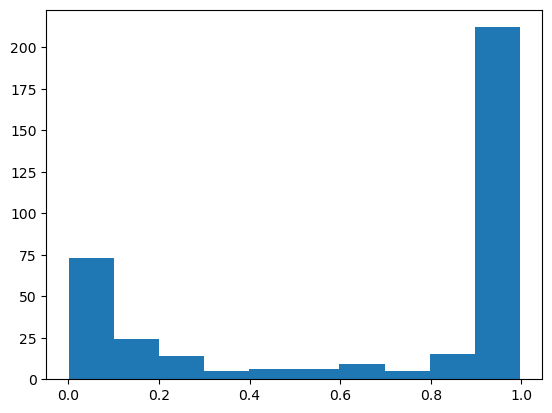

In [41]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([100.,  21.,  28.,  20.,  11.,  10.,   4.,   7.,   3., 165.]),
 array([5.68135176e-04, 1.00103624e-01, 1.99639112e-01, 2.99174607e-01,
        3.98710102e-01, 4.98245597e-01, 5.97781062e-01, 6.97316587e-01,
        7.96852052e-01, 8.96387577e-01, 9.95923042e-01]),
 <BarContainer object of 10 artists>)

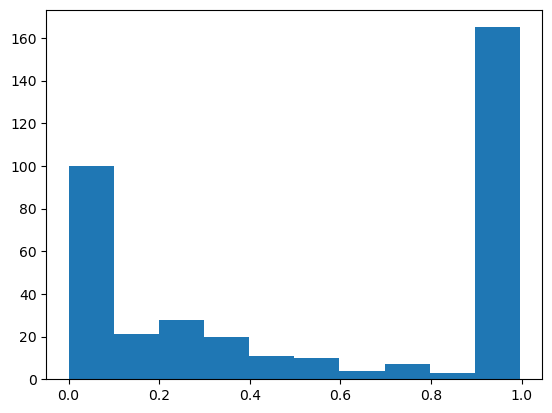

In [44]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 93.,  10.,   9.,   9.,   8.,  19.,  18.,  34.,  45., 124.]),
 array([0.00586221, 0.10454156, 0.2032209 , 0.30190024, 0.40057957,
        0.49925894, 0.59793824, 0.6966176 , 0.79529697, 0.89397627,
        0.99265563]),
 <BarContainer object of 10 artists>)

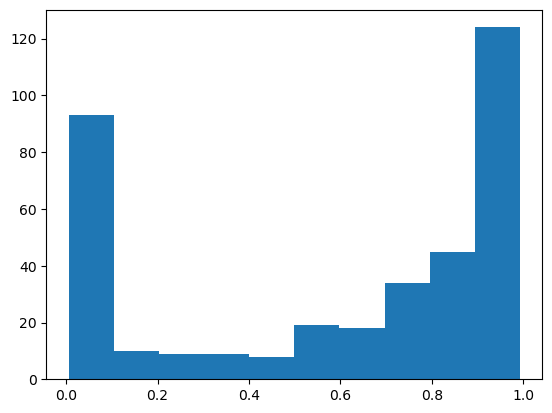

In [24]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 38.,  38.,  11.,   5.,   7.,  10.,  15.,  16.,  24., 205.]),
 array([0.00870654, 0.10700988, 0.20531322, 0.30361658, 0.40191993,
        0.50022328, 0.5985266 , 0.69682997, 0.79513329, 0.89343667,
        0.99173999]),
 <BarContainer object of 10 artists>)

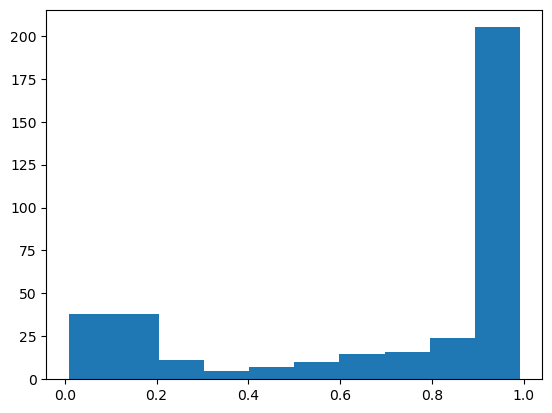

In [17]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)

(array([ 51.,  11.,   5.,  13.,   8.,  12.,   7.,   8.,  12., 242.]),
 array([0.00578006, 0.10388525, 0.20199043, 0.30009562, 0.39820081,
        0.49630597, 0.59441119, 0.69251633, 0.79062152, 0.88872671,
        0.9868319 ]),
 <BarContainer object of 10 artists>)

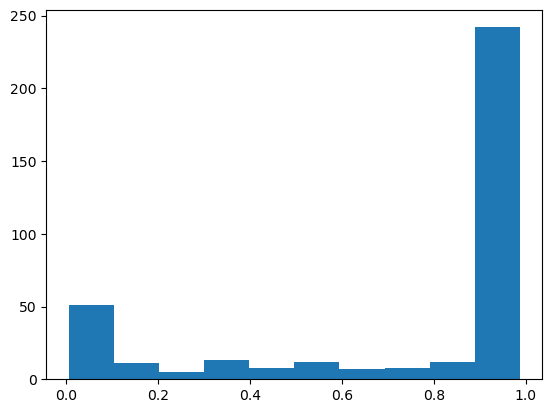

In [25]:
allres
import matplotlib.pyplot as plt
plt.hist(allres)